# Dataset generalization

## For every considered model, meta-learn on 16-dimensional halfspace dataset, then transfer rules, and train / test that on MNIST.

Created by Basile Van Hoorick, Fall 2020.

In [1]:
%run FF_common.ipynb

In [2]:
# IMPORTANT: Henceforth, we use GD directly on inputs but use plasticity rules in the output and hidden layers.
opts_up = Options(gd_input=True,
                  use_graph_rule=True,
                  gd_graph_rule=True,
                  use_output_rule=True,
                  gd_output_rule=True,
                  gd_output=False)
opts_down = Options(gd_input=True,
                    use_graph_rule=True,
                    gd_graph_rule=False,  # Not meta-trainable anymore!
                    use_output_rule=True,
                    gd_output_rule=False,  # Not meta-trainable anymore!
                    gd_output=False)
if 0:
    scheme = UpdateScheme(cross_entropy_loss=True,
                          mse_loss=False,
                          update_misclassified_only=False,
                          update_all_edges=True)
else:
    # Same as paper.
    scheme = UpdateScheme(cross_entropy_loss=True,
                          mse_loss=False,
                          update_misclassified_only=True,
                          update_all_edges=False)

# Feed-forward brain config.
n_up = 16  # Input layer size for meta-learning.
n_down = 28 * 28  # Input layer size for desired task training.
m_up = 2  # Output layer size for meta-learning.
m_down = 10  # Output layer size for desired task training.
l = 3  # Number of hidden layers.
w = 100  # Width of hidden layers.
p = 0.5  # Connectivity probability.
cap = 50  # Number of nodes firing per layer.

# Training config.
num_runs = 10
num_rule_epochs = 50
num_epochs_upstream = 1
num_epochs_downstream = 1
dataset_up = 'halfspace'
dataset_down = 'mnist'

In [3]:
# Instantiate brain factories.
brain_rnn_up_fact = lambda: LocalNet(n_up, m_up, w, p, cap, 2, options=opts_up, update_scheme=scheme)
brain_rnn_down_fact = lambda: LocalNet(n_down, m_down, w, p, cap, 2, options=opts_down, update_scheme=scheme)

brain_prepost_up_fact = lambda: FFLocalNet(
    n_up, m_up, l, w, p, cap, hl_rules=TableRule_PrePost(),
    output_rule=TableRule_PrePost(), options=opts_up, update_scheme=scheme)
brain_prepost_down_fact = lambda: FFLocalNet(
    n_down, m_down, l, w, p, cap, hl_rules=TableRule_PrePost(),
    output_rule=TableRule_PrePost(), options=opts_down, update_scheme=scheme)
brain_prepostcount_up_fact = lambda: FFLocalNet(
    n_up, m_up, l, w, p, cap, hl_rules=TableRule_PrePostCount(),
    output_rule=TableRule_PrePostCount(), options=opts_up, update_scheme=scheme)
brain_prepostcount_down_fact = lambda: FFLocalNet(
    n_down, m_down, l, w, p, cap, hl_rules=TableRule_PrePostCount(),
    output_rule=TableRule_PrePostCount(), options=opts_down, update_scheme=scheme)

brain_prepost_nonuni_up_fact = lambda: FFLocalNet(
    n_up, m_up, l, w, p, cap, hl_rules=[TableRule_PrePost(), TableRule_PrePost(), TableRule_PrePost()],
    output_rule=TableRule_PrePost(), options=opts_up, update_scheme=scheme)
brain_prepost_nonuni_down_fact = lambda: FFLocalNet(
    n_down, m_down, l, w, p, cap, hl_rules=[TableRule_PrePost(), TableRule_PrePost(), TableRule_PrePost()],
    output_rule=TableRule_PrePost(), options=opts_down, update_scheme=scheme)
brain_prepostcount_nonuni_up_fact = lambda: FFLocalNet(
    n_up, m_up, l, w, p, cap, hl_rules=[TableRule_PrePostCount(), TableRule_PrePostCount(), TableRule_PrePostCount()],
    output_rule=TableRule_PrePostCount(), options=opts_up, update_scheme=scheme)
brain_prepostcount_nonuni_down_fact = lambda: FFLocalNet(
    n_down, m_down, l, w, p, cap, hl_rules=[TableRule_PrePostCount(), TableRule_PrePostCount(), TableRule_PrePostCount()],
    output_rule=TableRule_PrePostCount(), options=opts_down, update_scheme=scheme)

In [4]:
# Evaluate models.
print('==== Original RNN (very different from all the rest) ====')
stats_rnn_up, stats_rnn_down = evaluate_up_down(
    brain_rnn_up_fact, brain_rnn_down_fact, n_up, n_down,
    dataset_up=dataset_up, dataset_down=dataset_down,
    downstream_backprop=False, num_runs=num_runs, num_rule_epochs=num_rule_epochs,
    num_epochs_upstream=num_epochs_upstream, num_epochs_downstream=num_epochs_downstream)

  0%|          | 0/50 [00:00<?, ?it/s]

==== Original RNN (very different from all the rest) ====

Run 1 / 1...
Meta-learning on halfspace...


100%|██████████| 50/50 [03:45<00:00,  4.51s/it]
../LocalNetBase.py:77: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.rnn_rule = torch.tensor(rule).flatten().double()


Last loss: 0.6931
Last train accuracy: 0.6447
Last test accuracy: 0.6540
mnist_train: 60000
mnist_test: 10000
Training NEW brain instance on mnist...
===> WARNING: Backprop is disabled, which means that all layers without rules will never change their weights!
===> This is NOT recommended by Basile!
INITIAL train accuracy: 0.0897
INITIAL test accuracy: 0.0885
Epoch 1 / 1 ...


100%|██████████| 60000/60000 [17:38<00:00, 56.69it/s]  


Last loss: 1.9732
Last train accuracy: 0.2355
Last test accuracy: 0.2398



In [5]:
print('==== Interpretation: PrePost (universal) ====')
stats_prepost_up, stats_prepost_down = evaluate_up_down(
    brain_prepost_up_fact, brain_prepost_down_fact, n_up, n_down,
    dataset_up=dataset_up, dataset_down=dataset_down,
    downstream_backprop=False, num_runs=num_runs, num_rule_epochs=num_rule_epochs,
    num_epochs_upstream=num_epochs_upstream, num_epochs_downstream=num_epochs_downstream)
print('==== Interpretation: PrePostCount (universal) ====')
stats_prepostcount_up, stats_prepostcount_down = evaluate_up_down(
    brain_prepostcount_up_fact, brain_prepostcount_down_fact, n_up, n_down,
    dataset_up=dataset_up, dataset_down=dataset_down,
    downstream_backprop=False, num_runs=num_runs, num_rule_epochs=num_rule_epochs,
    num_epochs_upstream=num_epochs_upstream, num_epochs_downstream=num_epochs_downstream)

  0%|          | 0/50 [00:00<?, ?it/s]

==== Interpretation: PrePost (universal) ====

Run 1 / 1...
Meta-learning on halfspace...


100%|██████████| 50/50 [04:32<00:00,  5.45s/it]


Last loss: 0.6931
Last train accuracy: 0.4873
Last test accuracy: 0.5160
mnist_train: 60000
mnist_test: 10000
Training NEW brain instance on mnist...
===> WARNING: Backprop is disabled, which means that all layers without rules will never change their weights!
===> This is NOT recommended by Basile!
INITIAL train accuracy: 0.0987
INITIAL test accuracy: 0.0980
Epoch 1 / 1 ...


  0%|          | 0/50 [00:00<?, ?it/s]


Last loss: 2.3026
Last train accuracy: 0.0987
Last test accuracy: 0.0980

==== Interpretation: PrePostCount (universal) ====

Run 1 / 1...
Meta-learning on halfspace...


100%|██████████| 50/50 [04:59<00:00,  5.99s/it]


Last loss: 0.5233
Last train accuracy: 0.5100
Last test accuracy: 0.4720
mnist_train: 60000
mnist_test: 10000
Training NEW brain instance on mnist...
===> WARNING: Backprop is disabled, which means that all layers without rules will never change their weights!
===> This is NOT recommended by Basile!
INITIAL train accuracy: 0.0987
INITIAL test accuracy: 0.0980
Epoch 1 / 1 ...


100%|██████████| 60000/60000 [15:33<00:00, 64.27it/s]  


Last loss: 2.3029
Last train accuracy: 0.0987
Last test accuracy: 0.0980



In [6]:
if 0:
    print('==== Interpretation: PrePost (NOT universal) ====')
    stats_prepost_nonuni_up, stats_prepost_nonuni_down = evaluate_up_down(
        brain_prepost_nonuni_up_fact, brain_prepost_nonuni_down_fact, n_up, n_down,
        dataset_up=dataset_up, dataset_down=dataset_down,
        downstream_backprop=False, num_runs=num_runs, num_rule_epochs=num_rule_epochs,
        num_epochs_upstream=num_epochs_upstream, num_epochs_downstream=num_epochs_downstream)
    print('==== Interpretation: PrePostCount (NOT universal) ====')
    stats_prepostcount_nonuni_up, stats_prepostcount_nonuni_down = evaluate_up_down(
        brain_prepostcount_nonuni_up_fact, brain_prepostcount_nonuni_down_fact, n_up, n_down,
        dataset_up=dataset_up, dataset_down=dataset_down,
        downstream_backprop=False, num_runs=num_runs, num_rule_epochs=num_rule_epochs,
        num_epochs_upstream=num_epochs_upstream, num_epochs_downstream=num_epochs_downstream)

Saving figure to: figs/generalization_rnn_halfspace_mnist


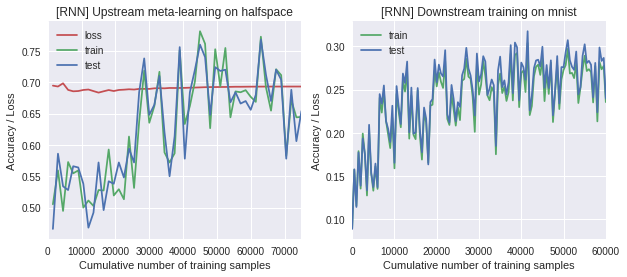

Mean essential stats across all runs:
Last upstream loss: 0.6931
Last upstream train accuracy: 0.6447
Last upstream test accuracy: 0.6540
Last downstream loss: 1.9732
Last downstream train accuracy: 0.2355
Last downstream test accuracy: 0.2398

Saving figure to: figs/generalization_prepost_uni_halfspace_mnist


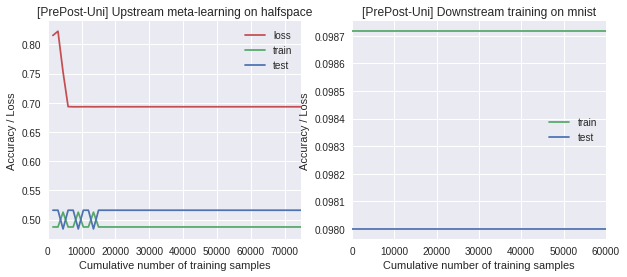

Mean essential stats across all runs:
Last upstream loss: 0.6931
Last upstream train accuracy: 0.4873
Last upstream test accuracy: 0.5160
Last downstream loss: 2.3026
Last downstream train accuracy: 0.0987
Last downstream test accuracy: 0.0980

Saving figure to: figs/generalization_prepostcount_uni_halfspace_mnist


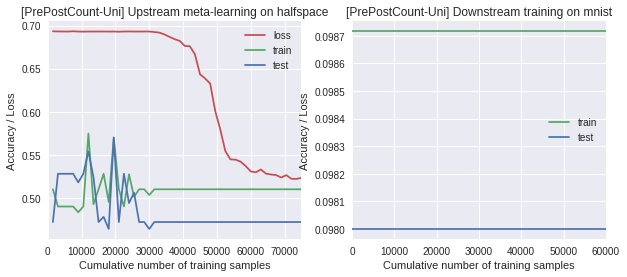

Mean essential stats across all runs:
Last upstream loss: 0.5233
Last upstream train accuracy: 0.5100
Last upstream test accuracy: 0.4720
Last downstream loss: 2.3029
Last downstream train accuracy: 0.0987
Last downstream test accuracy: 0.0980



In [7]:
# Plot aggregated stats.
agg_stats_rnn_up = convert_multi_stats_uncertainty(stats_rnn_up)
agg_stats_rnn_down = convert_multi_stats_uncertainty(stats_rnn_down)
plot_curves(agg_stats_rnn_up, agg_stats_rnn_down,
            '[RNN] Upstream meta-learning on ' + dataset_up,
            '[RNN] Downstream training on ' + dataset_down,
            'figs/generalization_rnn_' + dataset_up + '_' + dataset_down,
            no_downstream_loss=True)

agg_stats_prepost_up = convert_multi_stats_uncertainty(stats_prepost_up)
agg_stats_prepost_down = convert_multi_stats_uncertainty(stats_prepost_down)
plot_curves(agg_stats_prepost_up, agg_stats_prepost_down,
            '[PrePost-Uni] Upstream meta-learning on ' + dataset_up,
            '[PrePost-Uni] Downstream training on ' + dataset_down,
            'figs/generalization_prepost_uni_' + dataset_up + '_' + dataset_down,
            no_downstream_loss=True)
agg_stats_prepostcount_up = convert_multi_stats_uncertainty(stats_prepostcount_up)
agg_stats_prepostcount_down = convert_multi_stats_uncertainty(stats_prepostcount_down)
plot_curves(agg_stats_prepostcount_up, agg_stats_prepostcount_down,
            '[PrePostCount-Uni] Upstream meta-learning on ' + dataset_up,
            '[PrePostCount-Uni] Downstream training on ' + dataset_down,
            'figs/generalization_prepostcount_uni_' + dataset_up + '_' + dataset_down,
            no_downstream_loss=True)

if 0:
    agg_stats_prepost_nonuni_up = convert_multi_stats_uncertainty(stats_prepost_nonuni_up)
    agg_stats_prepost_nonuni_down = convert_multi_stats_uncertainty(stats_prepost_nonuni_down)
    plot_curves(agg_stats_prepost_nonuni_up, agg_stats_prepost_nonuni_down,
                '[PrePost-Uni] Upstream meta-learning on ' + dataset_up,
                '[PrePost-Uni] Downstream training on ' + dataset_down,
                'figs/generalization_prepost_nonuni_' + dataset_up + '_' + dataset_down,
                no_downstream_loss=True)
    agg_stats_prepostcount_nonuni_up = convert_multi_stats_uncertainty(stats_prepostcount_nonuni_up)
    agg_stats_prepostcount_nonuni_down = convert_multi_stats_uncertainty(stats_prepostcount_nonuni_down)
    plot_curves(agg_stats_prepostcount_nonuni_up, agg_stats_prepostcount_nonuni_down,
                '[PrePostCount-Uni] Upstream meta-learning on ' + dataset_up,
                '[PrePostCount-Uni] Downstream training on ' + dataset_down,
                'figs/generalization_prepostcount_nonuni_' + dataset_up + '_' + dataset_down,
                no_downstream_loss=True)

## Train vanilla net

In [8]:
# Instantiate model.
brain_vanilla = FFBrainNet(
    n_down, m_down, l, w, p, cap, full_gd=True)

In [ ]:
# Evaluate model.
print('==== Vanilla ====')
X_train, y_train, X_test, y_test = quick_get_data('mnist', 28 * 28)
print('Training VANILLA brain instance (WITH backprop) on mnist...')
stats_vanilla = train_downstream(
    X_train, y_train, brain_vanilla, num_epochs=num_epochs_downstream,
    batch_size=100, vanilla=True, learn_rate=5e-3,
    X_test=X_test, y_test=y_test, verbose=False, stats_interval=500)

==== Vanilla ====
mnist_train: 60000
mnist_test: 10000
Training VANILLA brain instance (WITH backprop) on mnist...
INITIAL train accuracy: 0.0968
INITIAL test accuracy: 0.0980
Epoch 1 / 1 ...


../train.py:258: TqdmMonitorWarning: tqdm:disabling monitor support (monitor_interval = 0) due to:
can't start new thread
  for k in tqdm(range(num_batches)):
  0%|          | 3/600 [00:54<3:01:34, 18.25s/it]

In [ ]:
# Plot aggregated stats.
plot_curves(None, stats_vanilla, None,
            '[Vanilla] Downstream training on ' + dataset_down,
            'figs/generalization_vanilla_' + dataset_down,
            no_downstream_loss=True)

In [ ]:
# Plot to compare some.
all_stats_up = [agg_stats_rnn_up, agg_stats_prepost_up, agg_stats_prepostcount_up, None]
all_stats_down = [agg_stats_rnn_down, agg_stats_prepost_down, agg_stats_prepostcount_down, stats_vanilla]
labels = ['RNN', 'PrePost', 'PrePostCount', 'Vanilla']
plot_compare_models(all_stats_up, all_stats_down, labels,
                    'Upstream meta-learning on ' + dataset_up,
                    'Downstream training on ' + dataset_down,
                    'figs/generalization_all_' + dataset_up + '_' + dataset_down)

In [ ]:
# Plot to compare all.
if 0:
    all_stats_up = [agg_stats_rnn_up, agg_stats_prepost_up, agg_stats_prepostcount_up, agg_stats_prepost_nonuni_up, agg_stats_prepostcount_nonuni_up, None]
    all_stats_down = [agg_stats_rnn_down, agg_stats_prepost_down, agg_stats_prepostcount_down, agg_stats_prepost_nonuni_down, agg_stats_prepostcount_nonuni_down, stats_vanilla]
    labels = ['RNN', 'PrePostUni', 'PrePostCountUni', 'PrePostNonUni', 'PrePostCountNonUni', 'Vanilla']
    plot_compare_models(all_stats_up, all_stats_down, labels,
                        'Upstream meta-learning on ' + dataset_up,
                        'Downstream training on ' + dataset_down,
                        'figs/generalization_all_' + dataset_up + '_' + dataset_down)